# Loading data

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
%cd ..

e:\AIO2024\ssl-in-medical-image-segmentation


In [3]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Utils.pieces import DotDict
from itertools import cycle
from Datasets.create_dataset import get_dataset, SkinDataset2, StrongWeakAugment2
from Models.Transformer.SwinUnet import SwinUnet
import torch.nn as nn
from Utils.losses import dice_loss
import torch.optim as optim

config = yaml.load(open("Configs/multi_train_local.yml"), Loader=yaml.FullLoader)
config["fold"] = 1
config = DotDict(config)
config

{'device': 'cuda',
 'seed': 1,
 'debug': False,
 'log': False,
 'data': {'name': 'lisc',
  'train_folder': 'processed_data/lisc/',
  'val_folder': 'processed_data/lisc/',
  'test_folder': 'processed_data/lisc/',
  'save_folder': 'checkpoints/lisc',
  'supervised_ratio': 0.125,
  'train_aug': True,
  'img_size': 224},
 'semi': {'conf_thresh': 0.85},
 'train': {'l_batchsize': 4,
  'u_batchsize': 4,
  'num_workers': 0,
  'num_epochs': 80,
  'num_iters': False,
  'optimizer': {'mode': 'adamw',
   'adamw': {'lr': '1e-4',
    'betas': [0.9, 0.999],
    'eps': '1e-8',
    'weight_decay': 0.05},
   'adam': {'lr': '1e-4', 'betas': [0.9, 0.999]}}},
 'test': {'only_test': False,
  'test_model_dir': '',
  'num_workers': 0,
  'batch_size': 5},
 'model_encoder_id': 0,
 'model_adapt': {'adapt_method': False, 'num_domains': 1},
 'swin': {'name': 'swin_large_patch4_window7_224_22k',
  'DROP_PATH_RATE': 0.2,
  'EMBED_DIM': 192,
  'DEPTHS': [2, 2, 18],
  'NUM_HEADS': [6, 12, 24],
  'WINDOW_SIZE': 7},
 'f

In [4]:
def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))


def get_current_consistency_weight(epoch):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    return 0.1 * sigmoid_rampup(epoch, 200.0)

In [5]:
dataset = get_dataset(
    config,
    img_size=config.data.img_size,
    supervised_ratio=config.data.supervised_ratio,
    train_aug=config.data.train_aug,
    k=config.fold,
    lb_dataset=SkinDataset2,
    ulb_dataset=StrongWeakAugment2,
)
print(dataset.keys())

l_train_loader = torch.utils.data.DataLoader(
    dataset["lb_dataset"],
    batch_size=config.train.l_batchsize,
    shuffle=True,
    num_workers=config.train.num_workers,
    pin_memory=True,
    drop_last=False,
)
print(len(l_train_loader))

u_train_loader = torch.utils.data.DataLoader(
    dataset["ulb_dataset"],
    batch_size=config.train.u_batchsize,
    shuffle=True,
    num_workers=config.train.num_workers,
    pin_memory=True,
    drop_last=False,
)
print(len(u_train_loader))

Train Data: 10_baso.npy - 200
Labeled Data: 12_eosi.npy - 25
Unlabeled Data: 10_baso.npy - 175
Val Data: 11_baso.npy - 50
dict_keys(['lb_dataset', 'ulb_dataset', 'val_dataset'])
7
44


In [8]:
source_dataset = zip(cycle(l_train_loader), u_train_loader)
for idx, (batch, batch_w_s) in enumerate(source_dataset):

    img = batch["image"].cuda().float()
    label = batch["label"].cuda().float()
    weak_batch = batch_w_s["img_w"].cuda().float()
    strong_batch = batch_w_s["img_s"].cuda().float()

    # print shape
    print("img shape: ", img.shape)
    print("label shape: ", label.shape)
    print("weak_batch shape: ", weak_batch.shape)
    print("strong_batch shape: ", strong_batch.shape)

    sup_batch_len = img.shape[0]
    unsup_batch_len = weak_batch.shape[0]

    # print information
    print("supervised batch size: ", sup_batch_len)
    print("unsupervised batch size: ", unsup_batch_len)

    break

img shape:  torch.Size([8, 3, 224, 224])
label shape:  torch.Size([8, 1, 224, 224])
weak_batch shape:  torch.Size([8, 3, 224, 224])
strong_batch shape:  torch.Size([8, 3, 224, 224])
supervised batch size:  8
unsupervised batch size:  8


# Inference

In [16]:
model = SwinUnet(img_size=config.data.img_size)
model = model.cuda()
output = model(img)
output = torch.sigmoid(output)

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [17]:
# check number of trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of trainable parameters: ", num_trainable_params)

# view model summary
print(model)

print("output shape: ", output.shape)

number of trainable parameters:  41380068
SwinUnet(
  (swin_unet): SwinTransformerSys(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=96, input_resolution=(56, 56), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=96, window_size=(7, 7), num_heads=3
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
     

In [20]:
# calculate loss
criterion = [nn.BCELoss(), dice_loss]

assert output.shape == label.shape
losses = []
for function in criterion:
    losses.append(function(output, label))

losses

[tensor(0.6674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.9491, device='cuda:0', grad_fn=<RsubBackward1>)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2042704].


outputs_weak shape:  torch.Size([8, 1, 224, 224])
outputs_weak_soft shape:  torch.Size([8, 1, 224, 224])
outputs_strong shape:  torch.Size([8, 1, 224, 224])
outputs_strong_soft shape:  torch.Size([8, 1, 224, 224])


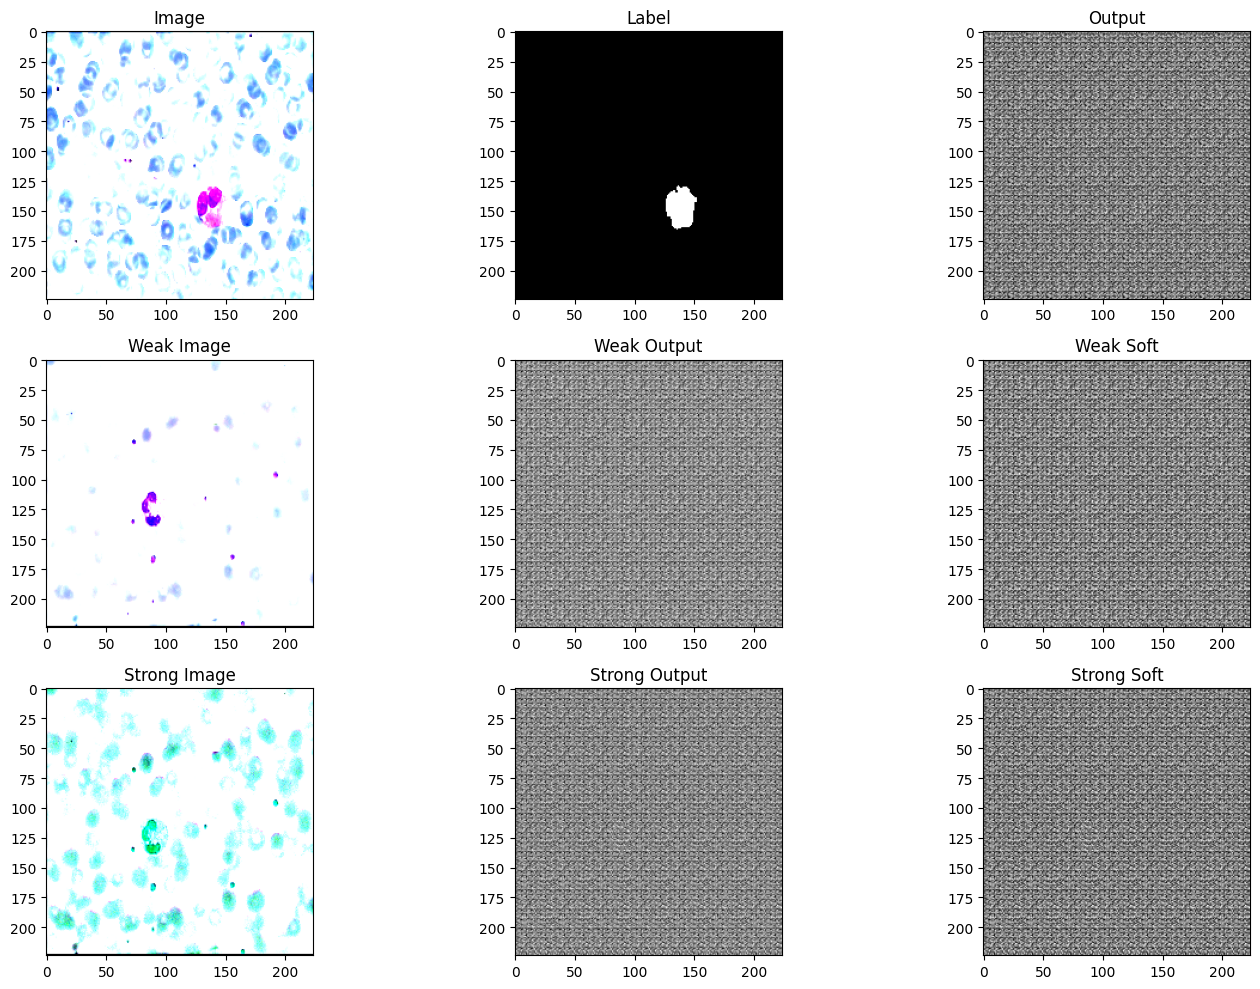

In [40]:
# outputs for model
outputs_weak = model(weak_batch)
outputs_weak_soft = torch.sigmoid(outputs_weak)
outputs_strong = model(strong_batch)
outputs_strong_soft = torch.sigmoid(outputs_strong)

print("outputs_weak shape: ", outputs_weak.shape)
print("outputs_weak_soft shape: ", outputs_weak_soft.shape)
print("outputs_strong shape: ", outputs_strong.shape)
print("outputs_strong_soft shape: ", outputs_strong_soft.shape)

# visualize outputs
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0, 0].imshow(img[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[0, 0].set_title("Image")
axs[0, 1].imshow(label[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[0, 1].set_title("Label")
axs[0, 2].imshow(output[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[0, 2].set_title("Output")

axs[1, 0].imshow(weak_batch[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[1, 0].set_title("Weak Image")
axs[1, 1].imshow(outputs_weak[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[1, 1].set_title("Weak Output")
axs[1, 2].imshow(
    outputs_weak_soft[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[1, 2].set_title("Weak Soft")

axs[2, 0].imshow(strong_batch[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[2, 0].set_title("Strong Image")
axs[2, 1].imshow(
    outputs_strong[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[2, 1].set_title("Strong Output")
axs[2, 2].imshow(
    outputs_strong_soft[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[2, 2].set_title("Strong Soft")

plt.tight_layout()
plt.show()

In [29]:
# minmax normalization for softmax outputs before applying mask
pseudo_mask = (outputs_weak_soft > config.semi.conf_thresh).float()
outputs_weak_masked = outputs_weak_soft * pseudo_mask
pseudo_outputs = torch.round(outputs_weak_masked)

In [56]:
series_pseudo = pd.Series(pseudo_mask.detach().cpu().numpy().flatten())
series_pseudo.describe()

count    401408.000000
mean          0.000012
std           0.003529
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [57]:
series_pseudo[series_pseudo == 1]

191515    1.0
248731    1.0
256795    1.0
263035    1.0
277531    1.0
dtype: float32

In [58]:
series_outputs_weak_masked = pd.Series(
    outputs_weak_masked.detach().cpu().numpy().flatten()
)
series_outputs_weak_masked.describe()

count    401408.000000
mean          0.000011
std           0.003026
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.867443
dtype: float64

In [60]:
series_pseudo_outputs = pd.Series(pseudo_outputs.detach().cpu().numpy().flatten())
series_pseudo_outputs.describe()

count    401408.000000
mean          0.000012
std           0.003529
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [59]:
# calculate loss
for function in criterion:
    losses.append(function(outputs_strong_soft, pseudo_outputs))

losses

[tensor(0.6674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.9491, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.6702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.9999, device='cuda:0', grad_fn=<RsubBackward1>)]

In [63]:
iter = 0
consistency_weight = get_current_consistency_weight(iter // 150)
sup_loss = (losses[0] + losses[1]) / 2
unsup_loss = (losses[2] + losses[3]) / 2
loss = sup_loss + unsup_loss * consistency_weight * (sup_batch_len / unsup_batch_len)

print("consistency weight: ", consistency_weight)
print("supervised loss: ", sup_loss)
print("unsupervised loss: ", unsup_loss)
print("total loss: ", loss)

consistency weight:  0.0006737946999085467
supervised loss:  tensor(0.8082, device='cuda:0', grad_fn=<DivBackward0>)
unsupervised loss:  tensor(0.8351, device='cuda:0', grad_fn=<DivBackward0>)
total loss:  tensor(0.8088, device='cuda:0', grad_fn=<AddBackward0>)


In [65]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=float(config.train.optimizer.adamw.lr),
    weight_decay=float(config.train.optimizer.adamw.weight_decay),
)


optimizer.zero_grad()
loss.backward()
optimizer.step()
loss_train_sum = 0
loss_train_sum += loss.item() * sup_batch_len

print("loss_train_sum: ", loss_train_sum)

loss_train_sum:  6.470451354980469


In [66]:
loss

tensor(0.8088, device='cuda:0', grad_fn=<AddBackward0>)

# Looping for training

In [6]:
train_loader = {"l_loader": l_train_loader, "u_loader": u_train_loader}
model = SwinUnet(img_size=config.data.img_size)
model = model.cuda()

# calculate loss
criterion = [nn.BCELoss(), dice_loss]

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1


c:\Users\predator\anaconda3\envs\ssl-in-medical-image-segmentation\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


In [12]:
import time
import medpy.metric.binary as metrics

# optimizer loss
if config.train.optimizer.mode == "adam":
    # optimizer = optim.Adam(model.parameters(), lr=float(config.train.optimizer.adam.lr))
    print("choose wrong optimizer")
elif config.train.optimizer.mode == "adamw":
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=float(config.train.optimizer.adamw.lr),
        weight_decay=float(config.train.optimizer.adamw.weight_decay),
    )
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ---------------------------------------------------------------------------
# Training and Validating
# ----------------------------------------------------------------------------
epochs = 1
max_iou = 0  # use for record best model
max_dice = 0  # use for record best model
best_epoch = 0  # use for recording the best epoch
# create training data loading iteration

# outputs for model
img = None
label = None
outputs_weak = None
outputs_weak_soft = None
outputs_strong = None
outputs_strong_soft = None


for epoch in range(epochs):
    start = time.time()
    # ----------------------------------------------------------------------
    # train
    # ---------------------------------------------------------------------
    model.train()
    dice_train_sum = 0
    iou_train_sum = 0
    loss_train_sum = 0
    num_train = 0
    iter = 0
    source_dataset = zip(cycle(train_loader["l_loader"]), train_loader["u_loader"])
    for idx, (batch, batch_w_s) in enumerate(source_dataset):
        img = batch["image"].cuda().float()
        label = batch["label"].cuda().float()
        weak_batch = batch_w_s["img_w"].cuda().float()
        strong_batch = batch_w_s["img_s"].cuda().float()

        sup_batch_len = img.shape[0]
        unsup_batch_len = weak_batch.shape[0]

        output = model(img)
        output = torch.sigmoid(output)

        # calculate loss
        assert output.shape == label.shape
        losses = []
        for function in criterion:
            losses.append(function(output, label))

        # FixMatch
        # ======================================================================================================
        # outputs for model
        outputs_weak = model(weak_batch)
        outputs_weak_soft = torch.sigmoid(outputs_weak)
        outputs_strong = model(strong_batch)
        outputs_strong_soft = torch.sigmoid(outputs_strong)

        # minmax normalization for softmax outputs before applying mask
        pseudo_mask = (outputs_weak_soft > config.semi.conf_thresh).float()
        outputs_weak_masked = outputs_weak_soft * pseudo_mask
        pseudo_outputs = torch.round(outputs_weak_masked)
        # calculate loss
        for function in criterion:
            losses.append(function(outputs_strong_soft, pseudo_outputs))
        # ======================================================================================================
        consistency_weight = get_current_consistency_weight(iter // 150)
        sup_loss = (losses[0] + losses[1]) / 2
        unsup_loss = (losses[2] + losses[3]) / 2
        loss = sup_loss + unsup_loss * consistency_weight * (
            sup_batch_len / unsup_batch_len
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train_sum += loss.item() * sup_batch_len

        # calculate metrics
        with torch.no_grad():
            output = output.cpu().numpy() > 0.5
            label = label.cpu().numpy()
            assert output.shape == label.shape
            dice_train = metrics.dc(output, label)
            iou_train = metrics.jc(output, label)
            dice_train_sum += dice_train * sup_batch_len
            iou_train_sum += iou_train * sup_batch_len

        print(
            "Epoch {}, iter {}, Dice Sup Loss: {}, Dice Unsup Loss: {}, BCE Sup Loss: {}, BCE UnSup Loss: {}\n".format(
                epoch,
                iter + 1,
                round(losses[1].item(), 5),
                round(losses[3].item(), 5),
                round(losses[0].item(), 5),
                round(losses[2].item(), 5),
            )
        )
        print(
            "Epoch {}, iter {}, Dice Sup Loss: {}, Dice Unsup Loss: {}, BCE Sup Loss: {}, BCE UnSup Loss: {}".format(
                epoch,
                iter + 1,
                round(losses[1].item(), 5),
                round(losses[3].item(), 5),
                round(losses[0].item(), 5),
                round(losses[2].item(), 5),
            )
        )

        num_train += sup_batch_len
        iter += 1

        # print
        print(
            "Epoch {}, Total train step {} || AVG_loss: {}, Avg Dice score: {}, Avg IOU: {}\n".format(
                epoch,
                iter,
                round(loss_train_sum / num_train, 5),
                round(dice_train_sum / num_train, 4),
                round(iou_train_sum / num_train, 4),
            )
        )
        print(
            "Epoch {}, Total train step {} || AVG_loss: {}, Avg Dice score: {}, Avg IOU: {}".format(
                epoch,
                iter,
                round(loss_train_sum / num_train, 5),
                round(dice_train_sum / num_train, 4),
                round(iou_train_sum / num_train, 4),
            )
        )

Epoch 0, iter 1, Dice Sup Loss: 0.1778, Dice Unsup Loss: 0.95009, BCE Sup Loss: 0.03869, BCE UnSup Loss: 0.08429

Epoch 0, iter 1, Dice Sup Loss: 0.1778, Dice Unsup Loss: 0.95009, BCE Sup Loss: 0.03869, BCE UnSup Loss: 0.08429
Epoch 0, Total train step 1 || AVG_loss: 0.1086, Avg Dice score: 0.8088, Avg IOU: 0.679

Epoch 0, Total train step 1 || AVG_loss: 0.1086, Avg Dice score: 0.8088, Avg IOU: 0.679
Epoch 0, iter 2, Dice Sup Loss: 0.21027, Dice Unsup Loss: 0.86756, BCE Sup Loss: 0.02833, BCE UnSup Loss: 0.10757

Epoch 0, iter 2, Dice Sup Loss: 0.21027, Dice Unsup Loss: 0.86756, BCE Sup Loss: 0.02833, BCE UnSup Loss: 0.10757
Epoch 0, Total train step 2 || AVG_loss: 0.11411, Avg Dice score: 0.7861, Avg IOU: 0.6481

Epoch 0, Total train step 2 || AVG_loss: 0.11411, Avg Dice score: 0.7861, Avg IOU: 0.6481
Epoch 0, iter 3, Dice Sup Loss: 0.18218, Dice Unsup Loss: 0.55118, BCE Sup Loss: 0.02484, BCE UnSup Loss: 0.09009

Epoch 0, iter 3, Dice Sup Loss: 0.18218, Dice Unsup Loss: 0.55118, BCE 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..1.541961].


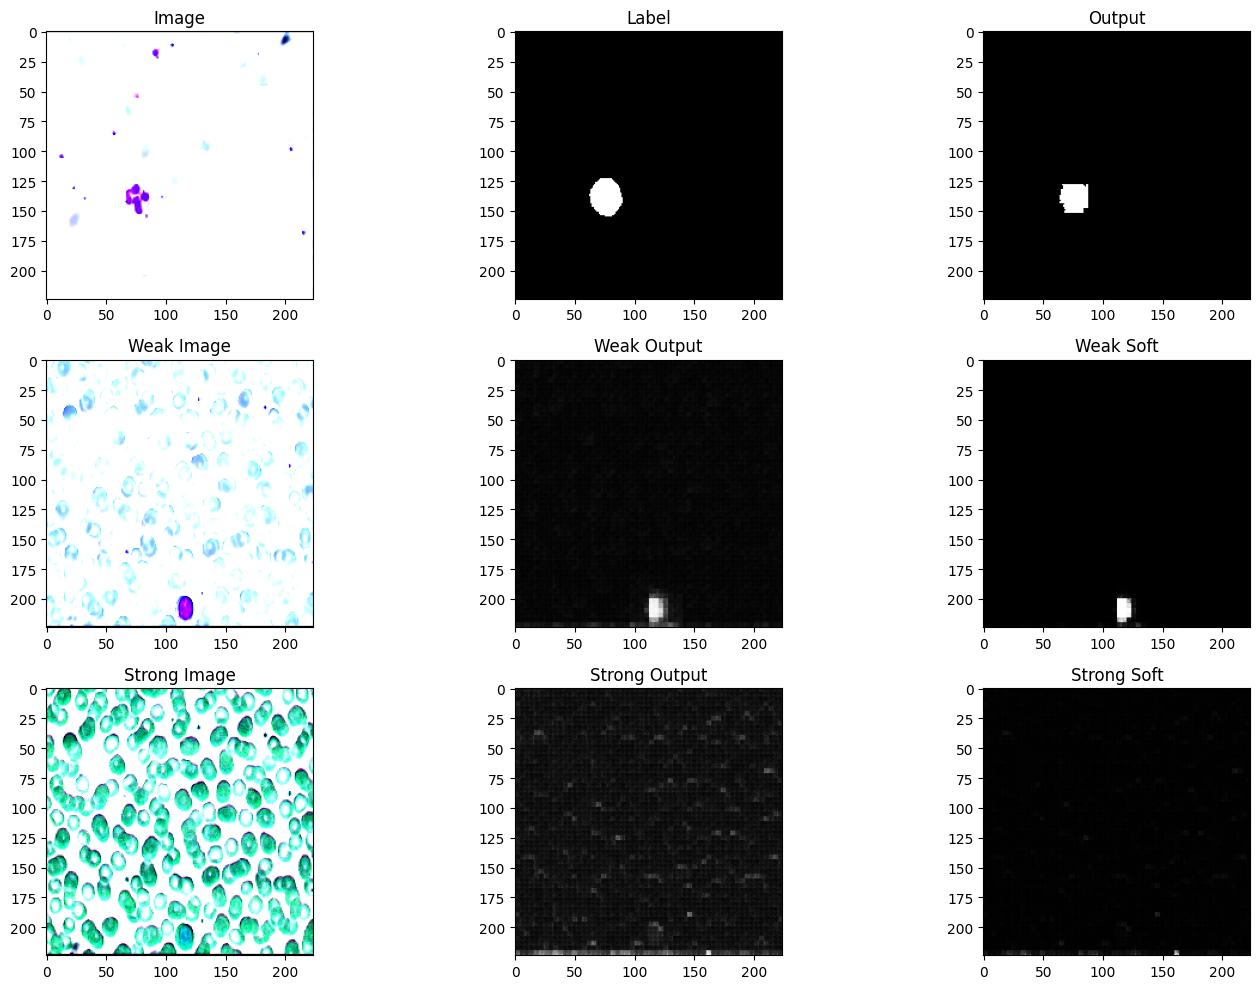

In [16]:
# visualize outputs
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0, 0].imshow(img[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[0, 0].set_title("Image")
axs[0, 1].imshow(label[0].transpose(1, 2, 0), cmap="gray")
axs[0, 1].set_title("Label")
axs[0, 2].imshow(output[0].transpose(1, 2, 0), cmap="gray")
axs[0, 2].set_title("Output")

axs[1, 0].imshow(weak_batch[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[1, 0].set_title("Weak Image")
axs[1, 1].imshow(outputs_weak[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[1, 1].set_title("Weak Output")
axs[1, 2].imshow(
    outputs_weak_soft[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[1, 2].set_title("Weak Soft")

axs[2, 0].imshow(strong_batch[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[2, 0].set_title("Strong Image")
axs[2, 1].imshow(
    outputs_strong[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[2, 1].set_title("Strong Output")
axs[2, 2].imshow(
    outputs_strong_soft[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray"
)
axs[2, 2].set_title("Strong Soft")

plt.tight_layout()
plt.show()

# Analyze results

In [7]:
from Models.CNN.ResNetBccd import resnet50

model_dir = "checkpoints/fold1/best.pth"
model = model = resnet50(
    pretrained=True, out_indices=[0, 1, 2, 3, 4], adapt_method=None
)
model = model.cuda()
model.load_state_dict(torch.load(model_dir))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\predator/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.9MB/s]


65 keys are not in the pretrain model: ['bn1.num_batches_tracked', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.bn2.num_batches_tracked', 'layer1.1.bn3.num_batches_tracked', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.bn2.num_batches_tracked', 'layer1.2.bn3.num_batches_tracked', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.bn2.num_batches_tracked', 'layer2.0.bn3.num_batches_tracked', 'layer2.0.downsample.1.num_batches_tracked', 'layer2.1.bn1.num_batches_tracked', 'layer2.1.bn2.num_batches_tracked', 'layer2.1.bn3.num_batches_tracked', 'layer2.2.bn1.num_batches_tracked', 'layer2.2.bn2.num_batches_tracked', 'layer2.2.bn3.num_batches_tracked', 'layer2.3.bn1.num_batches_tracked', 'layer2.3.bn2.num_batches_tracked', 'layer2.3.bn3.num_batches_tracked', 'layer3.0.bn1.num_batches_tracked', 'layer3.0.bn2.num_batches_tracked', 'layer3.0.bn3.n

C:\Users\predator\AppData\Local\Temp\ipykernel_13744\635866818.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [8]:
test_loader = torch.utils.data.DataLoader(
    dataset["val_dataset"],
    batch_size=config.test.batch_size,
    shuffle=False,
    num_workers=config.test.num_workers,
    pin_memory=True,
    drop_last=False,
)

In [9]:
for batch_id, batch in enumerate(test_loader):
    img = batch["image"].cuda().float()
    label = batch["label"].cuda().float()

    batch_len = img.shape[0]

    with torch.no_grad():

        output = model(img)

        output = torch.sigmoid(output)

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


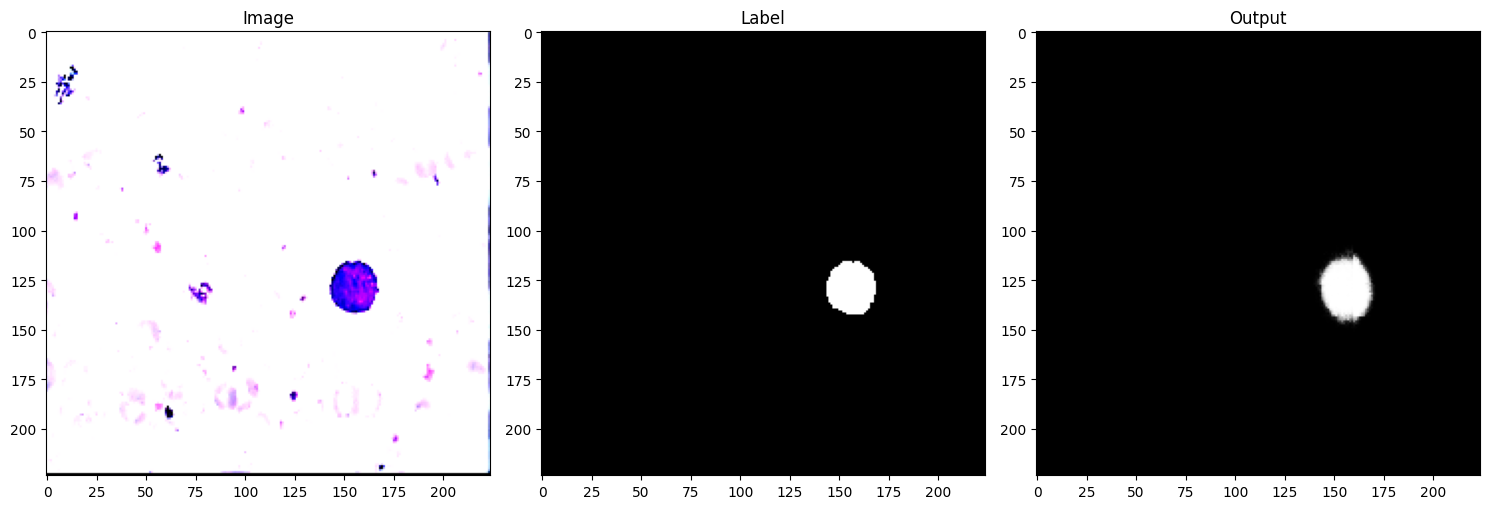

In [12]:
# visualize outputs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[0].set_title("Image")
axs[1].imshow(label[0].cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[1].set_title("Label")
axs[2].imshow(output[0].detach().cpu().numpy().transpose(1, 2, 0), cmap="gray")
axs[2].set_title("Output")

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

data = pd.Series([5, 7, 1])
data[[1, 2]]

1    7
2    1
dtype: int64